# Time Scaling and Multiple Waypoints

Consider the  time scaling function:

$\beta_i(t) = (t - S_{i-1})/T_i$

where:

* $T_i$ is the time duraction for the $i^{th}$ trajectory leg.
* $S_i$ is the time elapsed when the $i^{th}$ trajectory leg starts.
* $t$ is the elapsed time in seconds


This function is constructed so that:

* $\beta_i(S_{i-1}) = 0$

* $\beta_i(S_{i}) = 1$


This effectively scales time time so that the total duration for the segment is $T_i$.

Considering time scaling, we can construct trajectories using polynomial between waypoints as follows:

$p_i(\beta_i) = c_0 + c_1 \beta_i + c_2 \beta_i^2 + \ldots$

$p_i(\beta_i) = \sum \limits_{k=0}^{n} c_k \beta_i^k$

We will also need the derivatives of $p(\beta_i)$.

$p_i'(\beta_i) = \dfrac{dp}{d\beta_i} \dfrac{d\beta_i}{dt} = \sum \limits_{k=1}^{n} c_k \dfrac{k \beta_i^{(k - 1)}}{T}$

$p_i''(\beta_i) = \sum \limits_{k=2}^{n} c_k \dfrac{k (k-1) \beta_i^{(k - 2)}}{T^2}$

$p_i'''(\beta_i) = \sum \limits_{k=3}^{n} c_k \dfrac{k (k-1) (k-2) \beta_i^{(k - 3)}}{T^3}$

Notice there is a pattern for the $m^{th}$ derivative:

$p_i^{(m)}(\beta_i) = \sum \limits_{k=m}^{n} c_k \dfrac{k! \beta_i^{(k - m)}}{(k - m)! T^m}$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def time_scaling(t, t0, T):
    """
    @param t: elapsed time
    @param t0: initial time for start of leg
    @param T: duration for leg
    """
    return (t - t0)/T
    
def trajectory_coefficients(beta, m, n, T):
    """
    @param beta: scaled time
    @param m: derivative order, 0, for no derivative
    @param n: number of coeff in polynomial (order + 1)
    @param T: period
    """
    p = np.zeros(n)
    for k in range(m, n):
        p[n - k - 1] = (np.math.factorial(k)*beta**(k-m))/((np.math.factorial(k-m))*T**m)
    return p

def derivative(coef, Ti):
    c = []
    n = len(coef)
    for i in range(n-1):
        ci = (n-1-i)*coef[i]/Ti
        c.append(ci)
    c = np.array(c)
    return c

# Example

As a simple example, we use constraints of position and velocity at each waypoint. This will be 2 constraints on the end of each trajectory segment, and thus 4 total per trajectory segment.

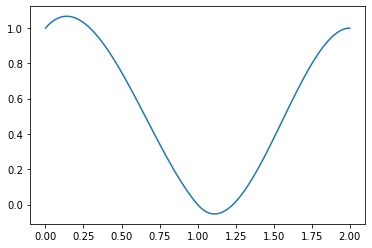

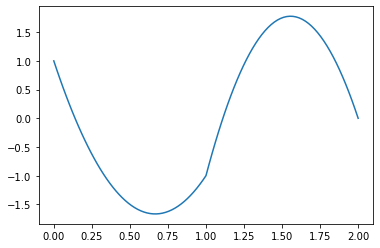

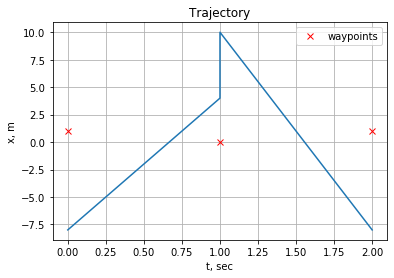

In [2]:
def find_trajectory(x_list, v_list, T, plot=False):
    n = 4 # this will be fixed to support 3rd order polynomials
    if not len(x_list) == len(T) + 1:
        raise ValueError('x_list must be 1 longer than T')
    if not len(x_list) == len(v_list):
        raise ValueError('x_list and v_list must be same length')

    S = np.hstack([[0], np.cumsum(T)])
    n_legs = len(T)
    n_coeff = n_legs*n
    A = np.zeros((n_coeff, n_coeff))
    b = np.zeros(n_coeff)

    eq_num = 0
    for i in range(n_legs):        
        # p1(0) = x[0]
        A[eq_num, n*i:n*(i+1)] = trajectory_coefficients(beta=0, m=0, n=n, T=T[i])
        b[eq_num] = x_list[i]
        eq_num += 1
    
        # p1'(0) = v[0]
        A[eq_num, n*i:n*(i+1)] = trajectory_coefficients(beta=0, m=1, n=n, T=T[i])
        b[eq_num] = v_list[i]
        eq_num += 1
    
        # p1(1) = x[1]
        A[eq_num, n*i:n*(i+1)] = trajectory_coefficients(beta=1, m=0, n=n, T=T[i])
        b[eq_num] = x_list[i + 1]
        eq_num += 1
    
        # p1'(1) = v[1]
        A[eq_num, n*i:n*(i+1)] = trajectory_coefficients(beta=1, m=1, n=n, T=T[i])
        b[eq_num] = v_list[i + 1]
        eq_num += 1

    rank = np.linalg.matrix_rank(A)
    if rank < n_coeff:
        print('Matrix A not full rank, check constraints, rank: ', rank, '/', n_coeff)
        c = np.linalg.pinv(A).dot(b)
    else:
        c = np.linalg.inv(A).dot(b)
        
    t = []
    x = []
    v = []
    a = []
    for i in range(len(T)):
        ti = np.linspace(S[i], S[i+1])
        beta = time_scaling(ti, S[i], T[i])
        cp = c[n*i:n*(i+1)]
        cv = derivative(cp, T[i])
        ca = derivative(cv, T[i])

        xi = np.polyval(cp, beta)
        vi = np.polyval(cv, beta)
        ai = np.polyval(ca, beta)

        t.append(ti)
        x.append(xi)
        v.append(vi)
        a.append(ai)

    x = np.hstack(x)
    v = np.hstack(v)
    a = np.hstack(a)
    t = np.hstack(t)
    return locals()

traj_data = find_trajectory(x_list=[1, 0, 1], v_list = [1, -1, 0], T=[1, 1]);
plt.figure()
plt.plot(traj_data['t'], traj_data['x']);

plt.figure()
plt.plot(traj_data['t'], traj_data['v']);

plt.figure()
plt.plot(traj_data['t'], traj_data['a']);

plt.plot(traj_data['S'], traj_data['x_list'], 'rx', label='waypoints')
plt.grid()
plt.xlabel('t, sec')
plt.ylabel('x, m')
plt.title('Trajectory')
plt.legend();


You now have the form:

$A c = b$

where:

* c are the coefficients
* b is your constraint vector
* A is your coefficient weighting matrix

You can solve this using the matrix inverse:
    
$c = A^{-1} b$

## 2D Trajectory Planning

Due to differential flatness, we may decouple the trajectory planning.

In [3]:
def plan_trajectory(T, waypoints):
    """
    Plan a trajectory and plot it.
    @param T: leg duraction vector [s],
    @param waypoints: position and velocity waypoint 2D array, each row: [px, py, vx, vy]
    """
    trajx = find_trajectory(x_list=waypoints[:, 0], v_list=waypoints[:, 2], T=T, plot=True)
    trajy = find_trajectory(x_list=waypoints[:, 1], v_list=waypoints[:, 3], T=T, plot=True)
    
    plt.figure()
    plt.plot(waypoints[:, 0], waypoints[:, 1], 'rx', label='waypoint')
    plt.plot(trajx['x'], trajy['x'], label='trajectory')
    plt.axis('equal')
    plt.grid()
    plt.xlabel('x, m')
    plt.ylabel('y, m')
    plt.legend(loc='best')
    
    plt.figure()
    plt.plot(trajx['t'], trajx['x'], label='x')
    plt.plot(trajx['t'], trajy['x'], label='y')
    plt.legend()
    plt.grid()
    return locals()

Text(0.5, 1.0, 'The same trajectory with 1/10 time scaling')

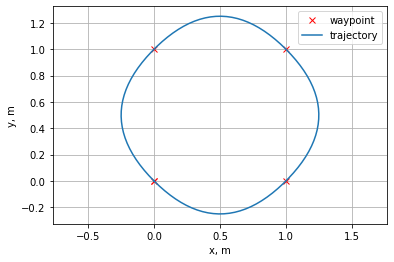

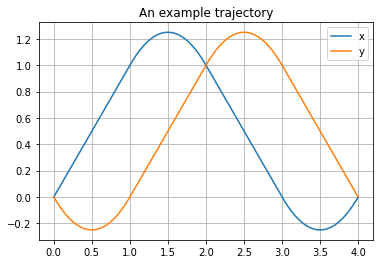

<Figure size 432x288 with 0 Axes>

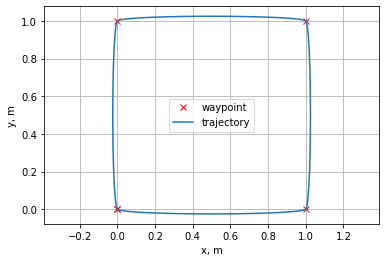

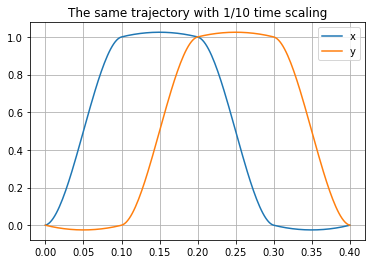

In [4]:
waypoints = np.array([
    # px, py, vx, vy
    [0, 0, 1, -1],
    [1, 0, 1, 1],
    [1, 1, -1, 1],
    [0, 1, -1, -1],
    [0, 0, 1, -1]
])
traj1 = plan_trajectory(T=[1, 1, 1, 1], waypoints=waypoints);
plt.title('An example trajectory')

plt.figure()
traj2 = plan_trajectory(T=[0.1, 0.1, 0.1, 0.1], waypoints=waypoints);
plt.title('The same trajectory with 1/10 time scaling')

These trajectory matrices and time scaling can be used for control of the crazyflie.